In [ ]:
# import file form gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0, MobileNetV2, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy

In [23]:
# Data paths
tb_dataset_dir = Path("/content/drive/MyDrive/data/TB Chest X-rays")
normal_dataset_dir = Path("/content/drive/MyDrive/data/Normal Chest X-rays")
base_output_dir = Path("/content/drive/MyDrive/data/split")

# Load image paths
tb_images = list(tb_dataset_dir.glob("**/*.jpg"))
normal_images = list(normal_dataset_dir.glob("**/*.jpg"))

In [24]:
# Remove corrupt images
def remove_corrupt(image_paths):
    valid_paths = []
    for path in image_paths:
        try:
            img = Image.open(path)
            img.verify()
            valid_paths.append(path)
        except:
            print(f"Removing corrupt image: {path}")
            continue
    return valid_paths

tb_images = remove_corrupt(tb_images)
normal_images = remove_corrupt(normal_images)

In [25]:
# Labels
tb_labels = [1] * len(tb_images)
normal_labels = [0] * len(normal_images)

# Combine & split
data_paths = tb_images + normal_images
labels = tb_labels + normal_labels
train_images, temp_images, train_labels, temp_labels = train_test_split(data_paths, labels, test_size=0.3, stratify=labels, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


In [27]:
# Move files
def move_files(file_list, labels, destination_dir):
    for file_path, label in zip(file_list, labels):
        label_dir = "TB" if label == 1 else "Normal"
        dest_folder = Path(destination_dir) / label_dir
        dest_folder.mkdir(parents=True, exist_ok=True)
        shutil.copy(file_path, dest_folder / file_path.name)

for split, imgs, lbls in zip(['train', 'val', 'test'], [train_images, val_images, test_images], [train_labels, val_labels, test_labels]):
    move_files(imgs, lbls, base_output_dir / split)

In [28]:
# ImageDataGenerators
image_size = (256, 256)
batch_size = 32

train_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_augmented = ImageDataGenerator(rescale=1.0/255)

train_data = train_augmented.flow_from_directory(
    base_output_dir / "train", target_size=image_size, batch_size=batch_size, class_mode="binary"
)
val_data = val_test_augmented.flow_from_directory(
    base_output_dir / "val", target_size=image_size, batch_size=batch_size, class_mode="binary"
)
test_data = val_test_augmented.flow_from_directory(
    base_output_dir / "test", target_size=image_size, batch_size=batch_size, class_mode="binary", shuffle=False
)


Found 2112 images belonging to 2 classes.
Found 453 images belonging to 2 classes.
Found 453 images belonging to 2 classes.


In [29]:
# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weight_dict = dict(enumerate(class_weights))


{'train': {'TB': 1752, 'Normal': 360}, 'val': {'TB': 376, 'Normal': 77}, 'test': {'TB': 376, 'Normal': 77}}


<Figure size 800x600 with 0 Axes>

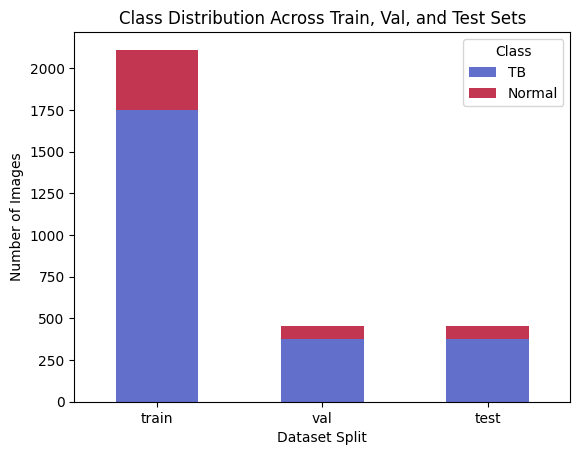

In [30]:
def count_images(directory):
    counts = {}
    for subset in ["train", "val", "test"]:
        subset_path = directory / subset
        counts[subset] = {
            "TB": len(list((subset_path / "TB").glob("*.*"))),
            "Normal": len(list((subset_path / "Normal").glob("*.*")))
        }
    return counts

image_counts = count_images(base_output_dir)
df_counts = pd.DataFrame(image_counts).T


print(image_counts)

# Class Distribution
plt.figure(figsize=(8, 6))
df_counts.plot(kind="bar", stacked=True, colormap="coolwarm", alpha=0.8)
plt.title("Class Distribution Across Train, Val, and Test Sets")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.legend(title="Class", loc="upper right")
plt.xticks(rotation=0)
plt.show()


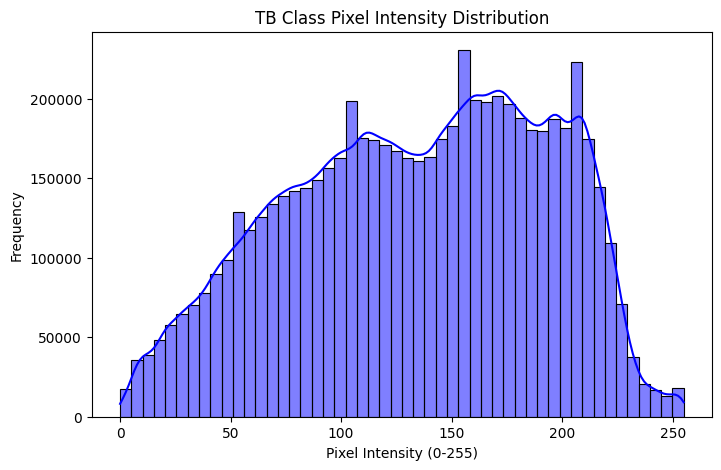

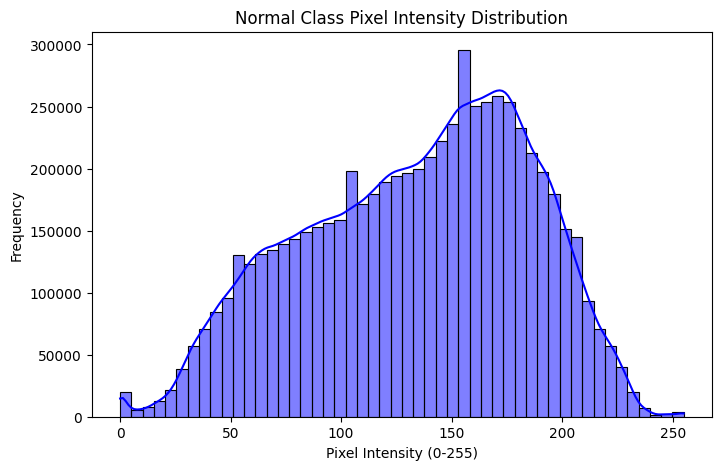

In [31]:
# Pixel Intensity Distribution
def plot_pixel_intensity(image_paths, title="Pixel Intensity Distribution"):
    intensities = []

    for img_path in image_paths[:100]:  # Limit to 100 images for speed
        img = cv.imread(str(img_path), cv.IMREAD_GRAYSCALE)  # Convert to grayscale
        if img is not None:
            intensities.extend(img.flatten())  # Flatten image to 1D array

    plt.figure(figsize=(8, 5))
    sns.histplot(intensities, bins=50, kde=True, color="blue")
    plt.title(title)
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Frequency")
    plt.show()

# Get a list of images for TB and Normal
tb_images = list((base_output_dir / "train" / "TB").glob("*.*"))
normal_images = list((base_output_dir / "train" / "Normal").glob("*.*"))

plot_pixel_intensity(tb_images, "TB Class Pixel Intensity Distribution")
plot_pixel_intensity(normal_images, "Normal Class Pixel Intensity Distribution")

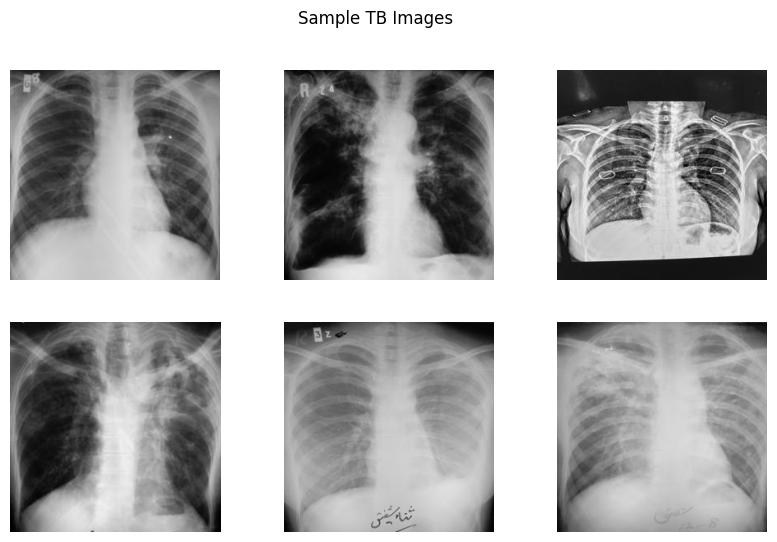

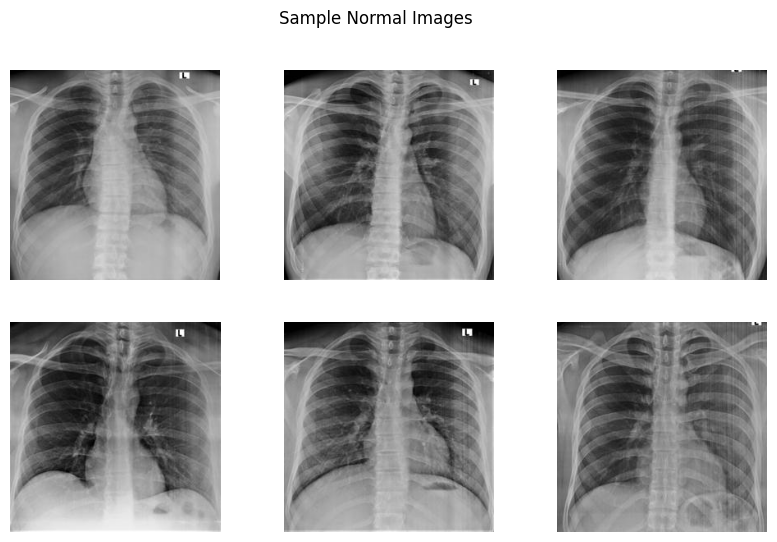

In [32]:
# Display Sample Images
def display_sample_images(image_paths, title="Sample Images"):
    num_samples = min(6, len(image_paths))  # Avoids errors when dataset is small
    if num_samples == 0:
        print(f"No images found for {title}.")
        return

    plt.figure(figsize=(10, 6))
    sample_images = np.random.choice(image_paths, num_samples, replace=False)

    for i, img_path in enumerate(sample_images):
        img = cv.imread(str(img_path))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert to RGB
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(title)
    plt.show()

display_sample_images(tb_images, "Sample TB Images")
display_sample_images(normal_images, "Sample Normal Images")

In [33]:
def build_model(base_model):
    base_model.trainable = True
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=BinaryCrossentropy(), metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [34]:
# Models to train
architectures = {
    "ResNet50": ResNet50,
    "VGG16": VGG16,
    "EfficientNetB0": EfficientNetB0,
    "MobileNetV2": MobileNetV2,
    "DenseNet121": DenseNet121
}

models = {name: build_model(arch(weights='imagenet', include_top=False, input_shape=(256, 256, 3))) for name, arch in architectures.items()}
history_dict = {}
epochs = 10

# Training loop
for name, model in models.items():
    print(f"\nTraining {name}...")
    history = model.fit(train_data, validation_data=val_data, epochs=epochs, class_weight=class_weight_dict)
    model.save(f"{name}.keras")
    history_dict[name] = history

<ipython-input-34-466e9dda3055>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  models = {name: build_model(arch(weights='imagenet', include_top=False, input_shape=(256, 256, 3))) for name, arch in architectures.items()}


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training ResNet50...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 782ms/step - accuracy: 0.5942 - auc: 0.6341 - loss: 0.6840 - val_accuracy: 0.8300 - val_auc: 0.8119 - val_loss: 0.6985
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 646ms/step - accuracy: 0.8410 - auc: 0.9209 - loss: 0.3634 - val_accuracy: 0.8300 - val_auc: 0.5025 - val_loss: 0.9749
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 630ms/step - accuracy: 0.8893 - auc: 0.9504 - loss: 0.2782 - val_accuracy: 0.8300 - val_auc: 0.8557 - val_loss: 0.8668
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 636ms/step - accuracy: 0.8795 - auc: 0.9538 - loss: 0.2687 - val_accuracy: 0.8300 - val_auc: 0.9438 - val_loss: 0.7885
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 632ms/step - accuracy: 0.9056 - auc: 0.9612 - loss: 0.2394 - val_accuracy: 0.8300 - val_auc: 0.9895 - val_loss: 0.3514
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 84s 656ms/step - accuracy: 0.9153 - auc: 0.9699 - loss: 0.2153 - val_accuracy: 0.8300 - val_auc: 0.7278 - val_loss: 0.9258
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━


Evaluating ResNet50...
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step
              precision    recall  f1-score   support

      Normal       1.00      0.01      0.03        77
          TB       0.83      1.00      0.91       376

    accuracy                           0.83       453
   macro avg       0.92      0.51      0.47       453
weighted avg       0.86      0.83      0.76       453

Confusion Matrix:
[[  1  76]
 [  0 376]]

Metrics:
Accuracy: 0.83
Precision: 0.83
Recall: 1.00
F1-score: 0.91
ROC-AUC: 0.99


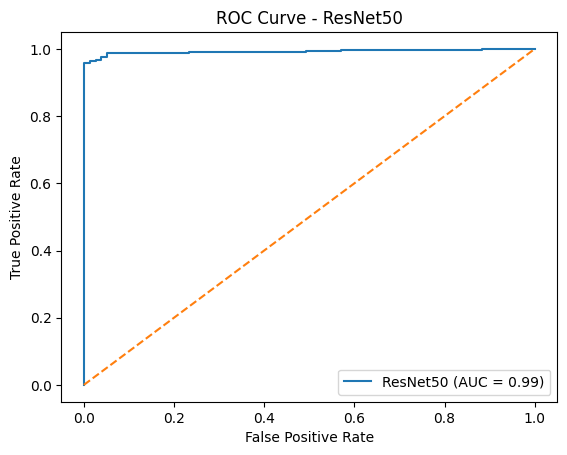


Evaluating VGG16...
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step
              precision    recall  f1-score   support

      Normal       0.89      1.00      0.94        77
          TB       1.00      0.97      0.99       376

    accuracy                           0.98       453
   macro avg       0.94      0.99      0.96       453
weighted avg       0.98      0.98      0.98       453

Confusion Matrix:
[[ 77   0]
 [ 10 366]]

Metrics:
Accuracy: 0.98
Precision: 1.00
Recall: 0.97
F1-score: 0.99
ROC-AUC: 1.00


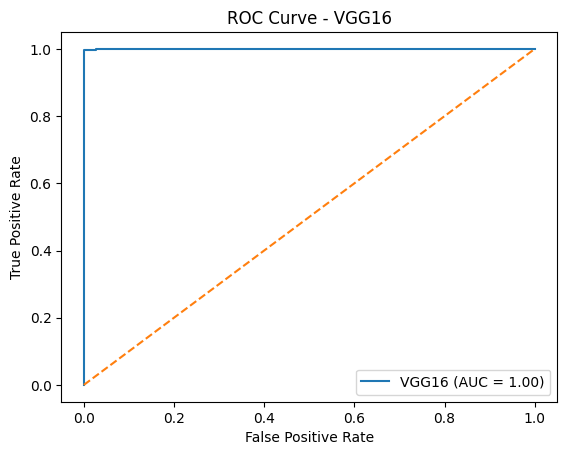


Evaluating EfficientNetB0...
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        77
          TB       0.83      1.00      0.91       376

    accuracy                           0.83       453
   macro avg       0.42      0.50      0.45       453
weighted avg       0.69      0.83      0.75       453

Confusion Matrix:
[[  0  77]
 [  0 376]]

Metrics:
Accuracy: 0.83
Precision: 0.83
Recall: 1.00
F1-score: 0.91
ROC-AUC: 0.94


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


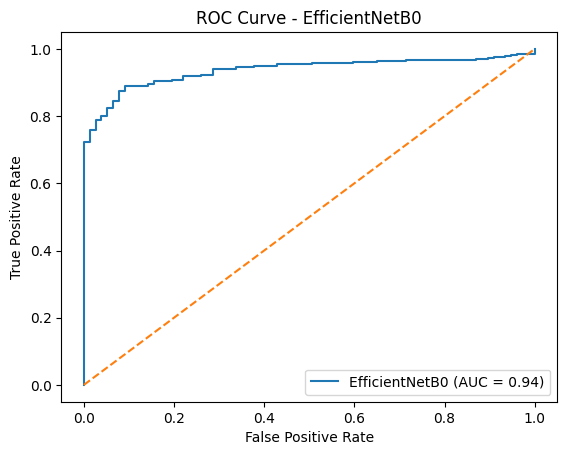


Evaluating MobileNetV2...
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
              precision    recall  f1-score   support

      Normal       0.88      1.00      0.93        77
          TB       1.00      0.97      0.99       376

    accuracy                           0.98       453
   macro avg       0.94      0.99      0.96       453
weighted avg       0.98      0.98      0.98       453

Confusion Matrix:
[[ 77   0]
 [ 11 365]]

Metrics:
Accuracy: 0.98
Precision: 1.00
Recall: 0.97
F1-score: 0.99
ROC-AUC: 1.00


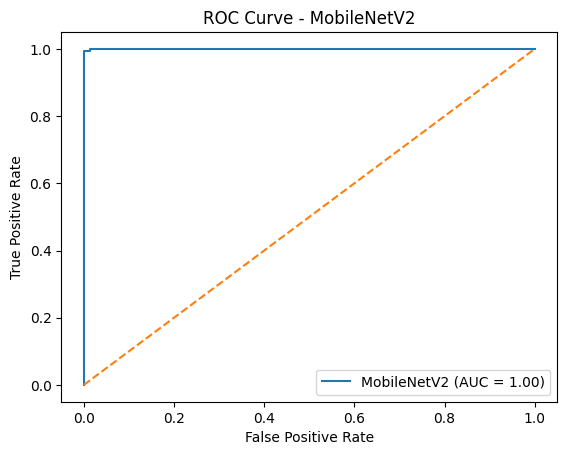


Evaluating DenseNet121...
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step
              precision    recall  f1-score   support

      Normal       0.89      1.00      0.94        77
          TB       1.00      0.97      0.99       376

    accuracy                           0.98       453
   macro avg       0.94      0.99      0.96       453
weighted avg       0.98      0.98      0.98       453

Confusion Matrix:
[[ 77   0]
 [ 10 366]]

Metrics:
Accuracy: 0.98
Precision: 1.00
Recall: 0.97
F1-score: 0.99
ROC-AUC: 1.00


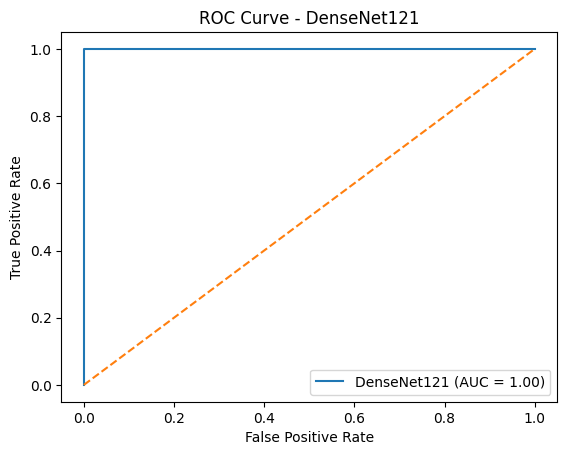

In [39]:
# Evaluation
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    y_true = test_data.classes
    y_pred_prob = model.predict(test_data).ravel()
    threshold = 0.5
    y_pred = (y_pred_prob > threshold).astype(int)

    print(classification_report(y_true, y_pred, target_names=["Normal", "TB"]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    print("\nMetrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision: {precision_score(y_true, y_pred):.2f}")
    print(f"Recall: {recall_score(y_true, y_pred):.2f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.2f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred_prob):.2f}")

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_true, y_pred_prob):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()
